(512, 512)

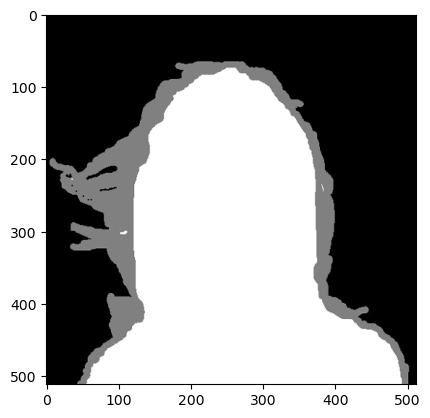

In [63]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image = Image.open("woman-trimap.png")
im = np.asarray(image)
org = Image.open("woman.png")
org_n = np.asarray(org)
org_g = Image.open("woman.png").convert('L')
org_g_n = np.asarray(org_g)
plt.imshow(image,cmap = "gray");
org_n.shape
im.shape

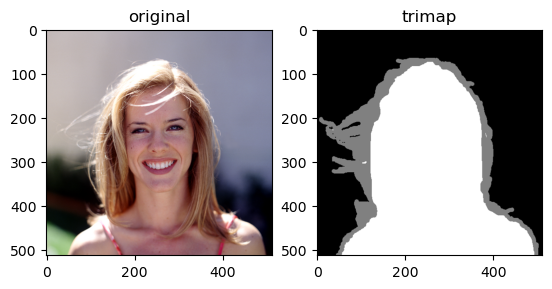

In [64]:
plt.subplot(121)
plt.title("original")
plt.imshow(org)
plt.subplot(122)
plt.title("trimap")
plt.imshow(image, cmap = "gray");

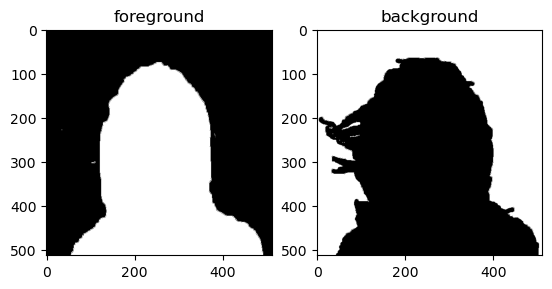

In [65]:
import cv2
fg = im == 255
bg = im == 0
plt.subplot(121)
plt.title("foreground")
plt.imshow(fg, cmap = "gray")
plt.subplot(122)
plt.title("background")
plt.imshow(bg, cmap = "gray");


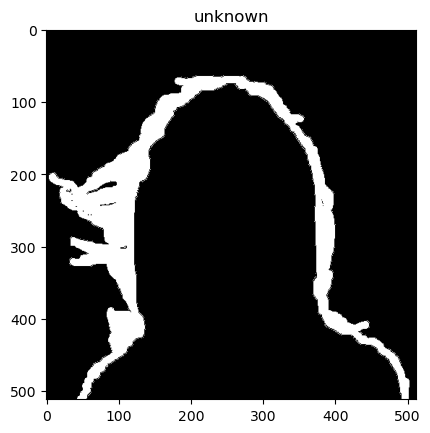

In [66]:
unknown = True^np.logical_or(fg,bg)
plt.title("unknown")
plt.imshow(unknown, cmap = "gray");

In [67]:
import cv2
gray_bg = org_g_n * bg
gray_fg = org_g_n * fg
not_fg = np.logical_not(fg)
bg_approx = cv2.inpaint(gray_bg.astype(np.uint8),(unknown + fg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_fg
bg_approx = bg_approx.astype(np.float32)
not_bg = np.logical_not(bg)
fg_approx = cv2.inpaint(gray_fg.astype(np.uint8),(unknown + bg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_bg
fg_approx = fg_approx.astype(np.float32)

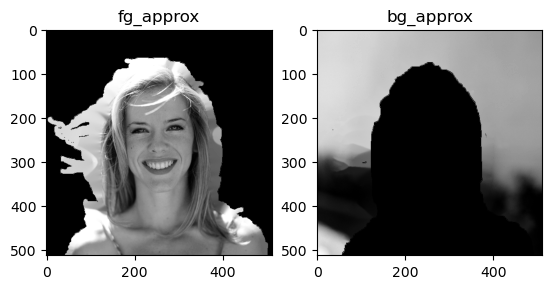

In [68]:
plt.subplot(121)
plt.title("fg_approx")
plt.imshow(fg_approx, cmap= "gray")
plt.subplot(122)
plt.title('bg_approx')
plt.imshow(bg_approx, cmap= "gray");

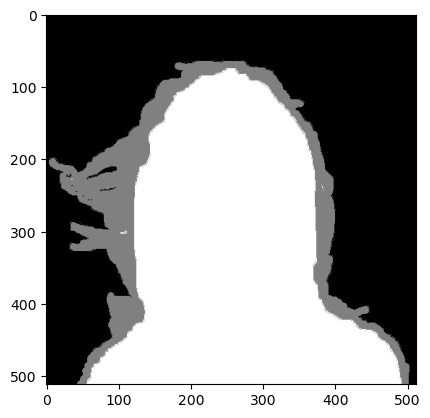

In [69]:
estimated_mate = fg + 0.5 * unknown
plt.imshow(fg + 0.5* unknown,cmap = "gray");

### finding approximate value of F-B

In [70]:
diff_approx = fg_approx - bg_approx
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)
import scipy
from scipy.ndimage import gaussian_filter
diff_approx = gaussian_filter(diff_approx, 0.9)
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)



$$
\alpha^* = \arg \min_{\alpha} \int_{\Omega} \left\| \nabla \alpha_p - \frac{\nabla I_p}{F_p - B_p} \right\|^2 \, dp
$$

$$
\left\| \nabla \alpha_p - \frac{\nabla I_p}{F_p - B_p} \right\|^2 = \left( \nabla \alpha_p - \frac{\nabla I_p}{F_p - B_p} \right) \cdot \left( \nabla \alpha_p - \frac{\nabla I_p}{F_p - B_p} \right)
$$


$$
\left\| \nabla \alpha_p \right\|^2 - 2 \nabla \alpha_p \cdot \frac{\nabla I_p }{F_p - B_p} + \left\| \frac{\nabla I_p}{F_p - B_p} \right\|^2
$$

$$
\int_{\Omega} \left( \left\| \nabla \alpha \right\|^2 - 2 \nabla \alpha \cdot \frac{\nabla I}{F_p - B_p} + \left\| \frac{\nabla I}{F_p - B_p} \right\|^2 \right) \, dp
$$

$$
J[\alpha] = \int_{\Omega} L(x, y, \alpha, \nabla \alpha) \, d\Omega
$$

The Euler-Lagrange equation for this functional is:

$$
\frac{\partial L}{\partial \alpha} - \nabla \cdot \left( \frac{\partial L}{\partial (\nabla \alpha)} \right) = 0
$$

For the image matting problem, the functional to minimize is:

$$
J[\alpha] = \int_{\Omega} \left\| \nabla \alpha - \frac{\nabla I}{F - B} \right\|^2 \, d\Omega
$$

Where \( L \) is:

$$
L = \left\| \nabla \alpha - \frac{\nabla I}{F - B} \right\|^2
$$



### Euler-Lagrange Equation and Poisson Equation Derivation

1. **Lagrangian:**

The Lagrangian \( L(\alpha, \nabla \alpha) \) is given by:

$$
L(\alpha, \nabla \alpha) = \|\nabla \alpha\|^2 - 2 \frac{\nabla \alpha \cdot \nabla I}{F - B}
$$

2. **Compute \( \frac{\partial L}{\partial \alpha} \):**

Since the Lagrangian does not explicitly depend on \( \alpha \), we have:

$$
\frac{\partial L}{\partial \alpha} = 0
$$

3. **Compute \( \frac{\partial L}{\partial (\nabla \alpha)} \):**

Now, compute the derivative of \( L \) with respect to \( \nabla \alpha \):

$$
\frac{\partial L}{\partial (\nabla \alpha)} = 2 \nabla \alpha - 2 \frac{\nabla I}{F - B}
$$

4. **Divergence Term:**

Next, apply the divergence operator to \( \frac{\partial L}{\partial (\nabla \alpha)} \):

$$
\nabla \cdot \left( \frac{\partial L}{\partial (\nabla \alpha)} \right) = \nabla \cdot \left( 2 \nabla \alpha - 2 \frac{\nabla I}{F - B} \right)
$$

Expanding this:

$$
\nabla \cdot (2 \nabla \alpha) - \nabla \cdot \left( 2 \frac{\nabla I}{F - B} \right)
$$

This simplifies to:

$$
2 \Delta \alpha - 2 \nabla \cdot \left( \frac{\nabla I}{F - B} \right)
$$

5. **Final Poisson Equation:**

Setting this equal to zero from the Euler-Lagrange equation:

$$
2 \Delta \alpha = 2 \nabla \cdot \left( \frac{\nabla I}{F - B} \right)
$$

Simplifying:

$$
\Delta \alpha = \nabla \cdot \left( \frac{\nabla I}{F - B} \right)
$$









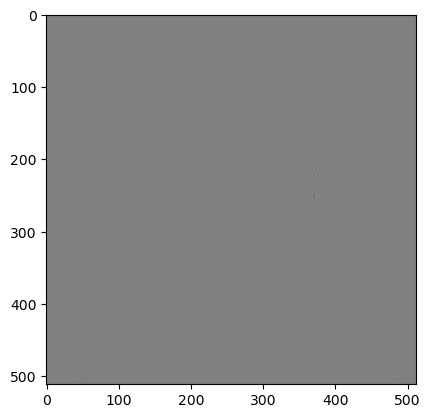

In [72]:
epsilon = 1e-8
dy, dx = np.gradient(image)


d2y, _ = np.gradient(dy / (diff_approx + epsilon))
_, d2x = np.gradient(dx / (diff_approx + epsilon))

b = d2x + d2y
# b = np.asarray(b)

plt.imshow(b,cmap = "gray")

#### using gauss seidel:

$$
\alpha_{i,j} = \frac{1}{4} \left( \alpha_{i+1,j} + \alpha_{i-1,j} + \alpha_{i,j+1} + \alpha_{i,j-1} - \nabla \cdot \left( \frac{\nabla I}{F-B}\right)_{i,j} \right)
$$




In [74]:
import numpy as np
h,w = fg.shape
def Alpha_matte_slow(alpha, b, c):

    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)

    threshold = 0.1
    max_iterations = 50
    h, w = alpha.shape  # Get shape from alpha input
    iterations = 1
    change = np.sum(np.abs(new_alpha - old_alpha))
    b = np.asarray(b)

    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        for i in range(1, h - 1):
            for j in range(1, w - 1):
                # Ensure c is an array and can be indexed
                if isinstance(c, np.ndarray) and c[i, j]:
                    # Ensure b is an array and can be indexed
                    if isinstance(b, np.ndarray):
                        new_alpha[i, j] = 1/4 * (new_alpha[i - 1, j] + new_alpha[i, j - 1] +
                                                old_alpha[i, j + 1] + old_alpha[i + 1, j] -
                                                b[i, j])
                    else:
                        raise TypeError("b must be a NumPy array for indexing")

        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha

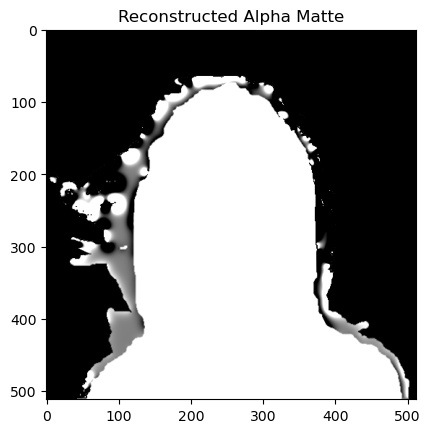

In [75]:
New_alpha = Alpha_matte_slow(estimated_mate, b,unknown)
New_alpha = np.clip(New_alpha, 0,1)
#New_alpha_slow = np.maximum(New_alpha_slow,0)
#New_alpha_slow = np.minimum(New_alpha_slow,1)
New_alpha_slow = New_alpha.reshape(h,w)   #yaha par new alpha slow hoga na ?????? kuch galat lag rah ahai

plt.imshow(New_alpha_slow, cmap='gray')
plt.title("Reconstructed Alpha Matte")
plt.show()


$$
I = \alpha F + (1 - \alpha) B
$$


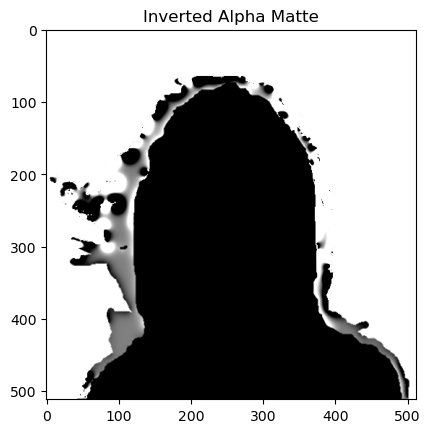

In [76]:

inverted_alpha = 1 - New_alpha_slow

plt.imshow(inverted_alpha, cmap='gray')
plt.title("Inverted Alpha Matte")
plt.show()

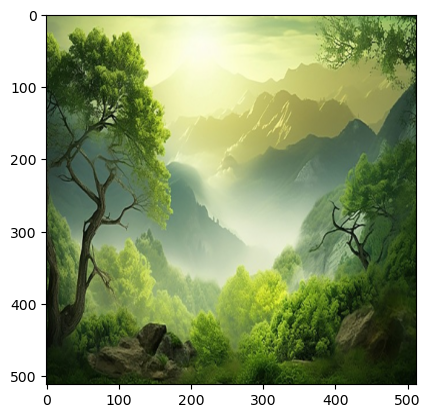

In [77]:
import imageio

image_i = imageio.v2.imread('bg.jpg')
a,b = fg.shape
resized_image = cv2.resize(image_i, (a, b))
plt.imshow(resized_image);

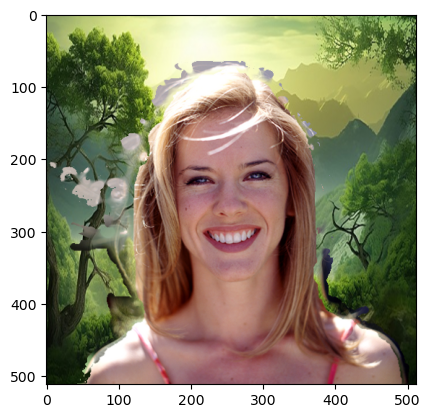

In [78]:
import imageio

bg_new = resized_image[0:h, 0:w, :]
final = np.zeros(bg_new.shape)

final[:, :, 0] = New_alpha * org_n[:, :, 0] + inverted_alpha * bg_new[:, :, 0]
final[:, :, 1] = New_alpha * org_n[:, :, 1] + inverted_alpha * bg_new[:, :, 1]
final[:, :, 2] = New_alpha * org_n[:, :, 2] + inverted_alpha * bg_new[:, :, 2]


plt.imshow(final/255)

$$
\text{We start with the functional:}
$$

$$
\alpha^* = \arg \min_{\alpha} \int_{\Omega} \left\| \nabla \alpha_p - A_p (\nabla I_p - D_p) \right\|^2 \, dp
$$

### 1. Expand the Norm

$$
\left\| \nabla \alpha_p - A_p (\nabla I_p - D_p) \right\|^2 = \left( \nabla \alpha_p - A_p (\nabla I_p - D_p) \right) \cdot \left( \nabla \alpha_p - A_p (\nabla I_p - D_p) \right)
$$

$$
= \|\nabla \alpha_p\|^2 - 2 \nabla \alpha_p \cdot \left(A_p (\nabla I_p - D_p)\right) + \|A_p (\nabla I_p - D_p)\|^2
$$

Substituting back into the integral:

$$
J[\alpha] = \int_{\Omega} \left( \|\nabla \alpha_p\|^2 - 2 \nabla \alpha_p \cdot \left(A_p (\nabla I_p - D_p)\right) + \|A_p (\nabla I_p - D_p)\|^2 \right) \, dp
$$

We focus only on terms involving \(\alpha\), as \(\|A_p (\nabla I_p - D_p)\|^2\) is independent of \(\alpha\):

$$
J[\alpha] = \int_{\Omega} \|\nabla \alpha_p\|^2 - 2 \nabla \alpha_p \cdot \left(A_p (\nabla I_p - D_p)\right) \, dp
$$

### 2. Identify the Lagrangian

The relevant Lagrangian \(L\) is:

$$
L(\alpha, \nabla \alpha) = \|\nabla \alpha\|^2 - 2 \nabla \alpha \cdot \left(A (\nabla I - D)\right)
$$

### 3. Compute \(\frac{\partial L}{\partial \alpha}\)

Since \(L\) does not explicitly depend on \(\alpha\):

$$
\frac{\partial L}{\partial \alpha} = 0
$$

### 4. Compute \(\frac{\partial L}{\partial (\nabla \alpha)}\)

Taking the derivative of \(L\) with respect to \(\nabla \alpha\):

$$
\frac{\partial L}{\partial (\nabla \alpha)} = 2 \nabla \alpha - 2 A (\nabla I - D)
$$

### 5. Apply the Divergence Operator

Now apply the divergence operator to \(\frac{\partial L}{\partial (\nabla \alpha)}\):

$$
\nabla \cdot \left( \frac{\partial L}{\partial (\nabla \alpha)} \right) = \nabla \cdot \left( 2 \nabla \alpha - 2 A (\nabla I - D) \right)
$$

Expanding this:

$$
\nabla \cdot (2 \nabla \alpha) - \nabla \cdot \left( 2 A (\nabla I - D) \right)
$$

Simplifies to:

$$
2 \Delta \alpha - 2 \nabla \cdot \left(A (\nabla I - D)\right)
$$

### 6. Combine and Simplify

Substitute into the Euler-Lagrange equation:

$$
\frac{\partial L}{\partial \alpha} - \nabla \cdot \left( \frac{\partial L}{\partial (\nabla \alpha)} \right) = 0
$$

Since $$(\frac{\partial L}{\partial \alpha} = 0\)$$, we have:

$$
2 \Delta \alpha - 2 \nabla \cdot \left(A (\nabla I - D)\right) = 0
$$

Divide through by 2:

$$
\Delta \alpha = \nabla \cdot \left(A (\nabla I - D)\right)
$$

### 7. Substituting $$(A)$$ and $$(D)$$

Given:

$$
A = \frac{1}{F - B}, \quad D = \alpha \nabla F + (1 - \alpha) \nabla B
$$

Substitute $$(A)$$ and $$(D)$$ into the equation:

$$
\Delta \alpha = \nabla \cdot \left( \frac{1}{F - B} \left( \nabla I - D \right) \right)
$$

Substitute \(D = \alpha \nabla F + (1 - \alpha) \nabla B\):

$$
\nabla I - D = \nabla I - \alpha \nabla F - (1 - \alpha) \nabla B
$$

$$
= \nabla I - \alpha \nabla F - \nabla B + \alpha \nabla B
$$

$$
= \nabla I - \nabla B - \alpha (\nabla F - \nabla B)
$$

Thus, the equation becomes:

$$
\Delta \alpha = \nabla \cdot \left( \frac{1}{F - B} \left( \nabla I - \nabla B - \alpha (\nabla F - \nabla B) \right) \right)
$$

In [79]:
#Local Poisson Matting
def local_poisson_matte(starth, endh, startw, endw):
    local_matte = np.zeros((h,w))

    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)


    seg1 = org_g_n[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]

    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx20)
    _, d2xfg = np.gradient(dxfg/diff_approx20)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx20)
    _, d2xbg = np.gradient(dxbg/diff_approx20)


    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx20)
    _, d2x = np.gradient(dx/diff_approx20)


    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = New_alpha[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg

    b_seg = d2y + d2x -(Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))


    matte = Alpha_matte_slow(Estimate_alpha_seg, b_seg,unknown_seg)
    return matte

In [80]:

new_local_matte = np.zeros_like(org_g)

for i in range(0,h):
    for j in range(0,w):
        new_local_matte[i, j] = New_alpha[i,j]

starth = 100
endh = 400
startw = 300
endw = 450
new_local_matte[starth:endh+1,startw:endw+1] = local_poisson_matte(starth, endh, startw, endw)

/var/folders/5x/0kh2v32d1b3dzh68c5hddrh00000gn/T/ipykernel_13273/1904888012.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)


In [81]:
new_local_matte = np.maximum(new_local_matte,0)
new_local_matte = np.minimum(new_local_matte,1)
new_local_matte = new_local_matte.reshape(h,w)

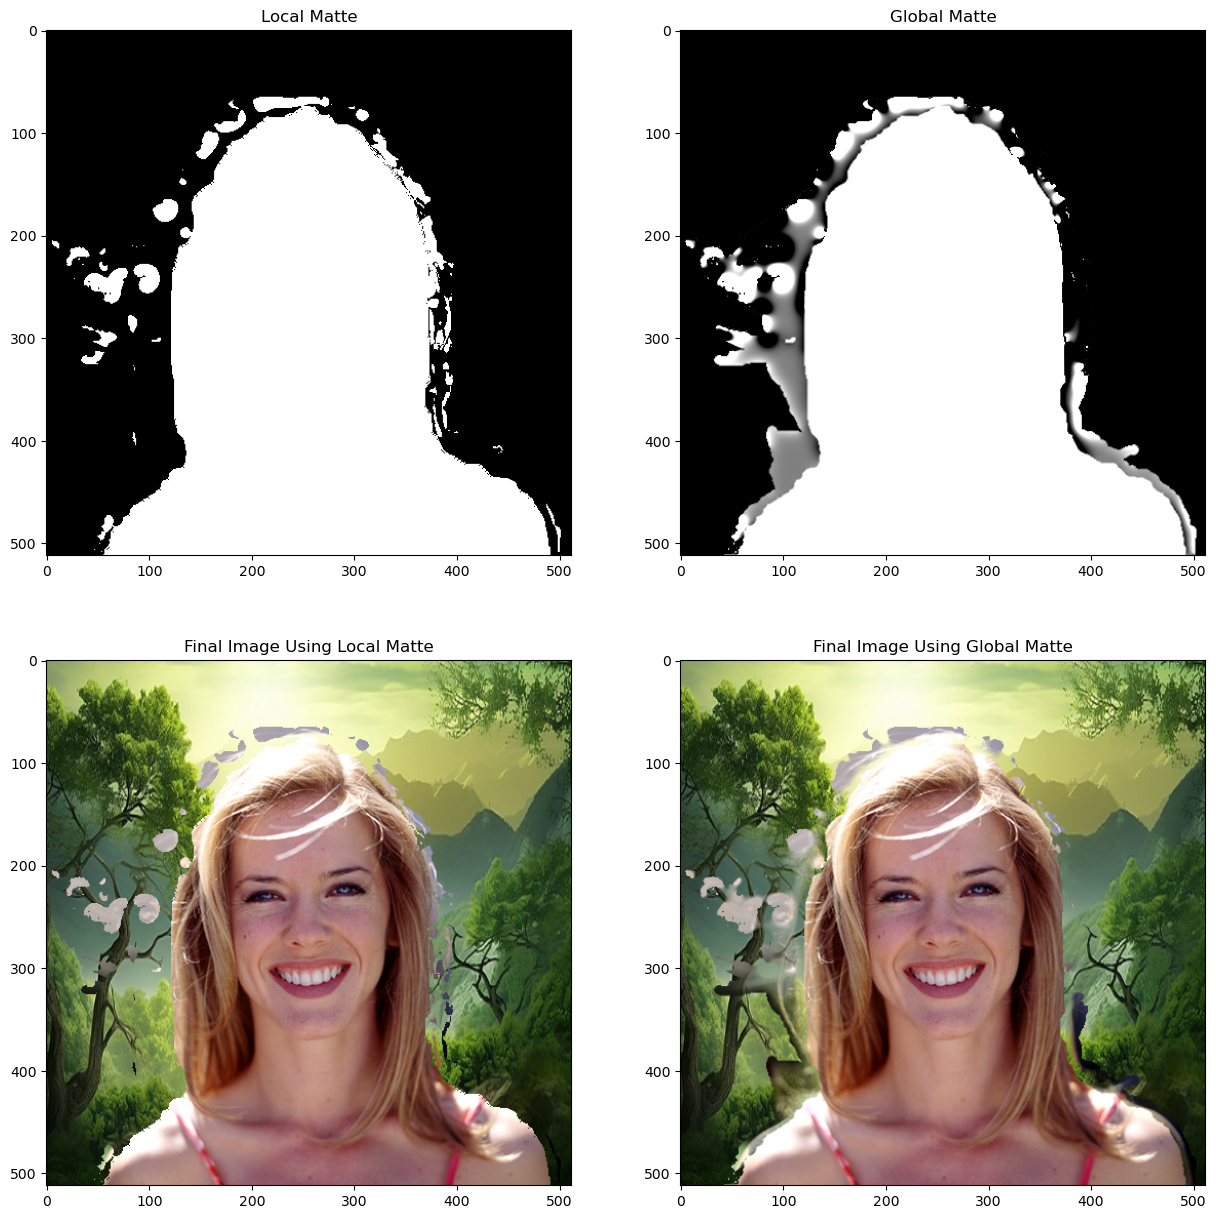

In [82]:


#bg_new = imageio.imread('bg.jpg')
bg_new = bg_new[0:h, 0:w, :]
final_seg = np.zeros(bg_new.shape)
inverted_alpha = 1 - new_local_matte

final_seg[:, :, 0] = new_local_matte * org_n[:, :, 0] + inverted_alpha * bg_new[:, :, 0]
final_seg[:, :, 1] = new_local_matte * org_n[:, :, 1] + inverted_alpha * bg_new[:, :, 1]
final_seg[:, :, 2] = new_local_matte * org_n[:, :, 2] + inverted_alpha * bg_new[:, :, 2]

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(new_local_matte,cmap='gray')
plt.title("Local Matte")
plt.subplot(222)
plt.imshow(New_alpha,cmap='gray')
plt.title("Global Matte")
plt.subplot(223)
plt.imshow(final_seg/255)
plt.title("Final Image Using Local Matte")
plt.subplot(224)
plt.imshow(final/255)
plt.title("Final Image Using Global Matte")
plt.show()

### Boosting Brush for Matting Adjustment

When the matting result is either smoother or sharper than desired, a *boosting brush* can be employed to directly modify \( A \). This brush enables users to increase or decrease \( A \) within a localized region. The boosting brush applies a Gaussian adjustment to each pixel \( p \) within its area, modifying \( A_p \) as follows:

$$
A_p = \left[1 + \lambda \exp\left(-\frac{\|p - p_0\|^2}{2\sigma^2}\right)\right] \cdot A_p
$$

#### Parameters and Effect

- **Brush Center (p_0))**:
- **Gaussian Width (sigma)**: Determines the size of the boosting effect.
- **Boosting Strength (lambda)**: Controls the intensity of the effect:
   -If \lambda > 0: A_p is increased around the brush center, making the matting sharper.
   -If \lambda < 0: A_p is decreased around the brush center, making the matting smoother.

By adjusting sigma and lambda, users can fine-tune the matting results, targeting either the entire region or specific areas using brushes of varying sizes.

In [92]:


def boosting(alpha_matte,starth, endh, startw, endw):

    local_matte = np.zeros((h,w))
    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)
    mh = endh - starth +1
    mw = endw-startw +1

    seg1 = org_g_n[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]

    A = np.zeros((h,w))
    lambda_ = 5
    sigma = 20
    x0 = starth + mh/2
    y0 = startw + mw/2

    for x in range(starth,endh+1+1):
      for y in range(startw,endw+1+1):
        A[x,y] = (1 + lambda_*np.exp(-1*((abs(x-x0)**2+(abs(y-y0))**2))/(2*sigma**2)))*(1/diff_approx[x,y])
    diff_approx2 = 1/A[starth:endh+1,startw:endw+1]

    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx2)
    _, d2xfg = np.gradient(dxfg/diff_approx2)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx2)
    _, d2xbg = np.gradient(dxbg/diff_approx2)

    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx2)
    _, d2x = np.gradient(dx/diff_approx2)


    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = alpha_matte[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))

    b_seg1 = d2y + d2x - D
    matte1 = Alpha_matte_slow(Estimate_alpha_seg, b_seg1,unknown_seg)

    return matte1

### Highpass Filtering for Gradient Estimation

To estimate \( D \), the low-frequency component of the image gradient is used:

$$
D = K \ast \nabla I
$$

where:
- $$( K = N(p; p_0, \sigma^2) )$$: A Gaussian filter centered at pixel \( p_0 \),
- K : The convolution operator.

From Equation, the gradient of \( \alpha \) can be expressed as:

$$
\nabla \alpha = A (\nabla I - K \ast \nabla I)
$$

Here:
- 
$$( \nabla I - K \ast \nabla I )$$: Corresponds to a highpass filter

In [84]:


def high_pass(alpha_matte,starth, endh, startw, endw):
    local_matte = np.zeros((h,w))
    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)
    mh = endh - starth +1
    mw = endw-startw +1

    seg1 = org_g_n[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]

    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx20)
    _, d2xfg = np.gradient(dxfg/diff_approx20)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx20)
    _, d2xbg = np.gradient(dxbg/diff_approx20)

    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx20)
    _, d2x = np.gradient(dx/diff_approx20)


    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = alpha_matte[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))

    refined_D = cv2.GaussianBlur(seg1,(3,3),0)
    b_seg = d2y + d2x - refined_D
    matte = Alpha_matte_slow(Estimate_alpha_seg, b_seg,unknown_seg)

    return matte

In [85]:


new_local_matte = np.zeros_like(org_g)

for i in range(0,h):                #New_alpha is actually part of global matte
    for j in range(0,w):
        new_local_matte[i, j] = New_alpha[i,j]


starth = 120
endh = 380
startw = 320
endw = 400
new_local_matte[starth:endh+1,startw:endw+1] = high_pass(new_local_matte,starth, endh, startw, endw)

# starth = 0
# endh = 480
# startw = 0
# endw = 480
# new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

starth = 100
endh = 320
startw = 0
endw = 200
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)


starth = 300
endh = 450
startw = 50
endw = 150
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

starth = 50
endh =150
startw = 150
endw = 310
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)


starth = 350
endh = 450
startw = 400
endw = 450
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

starth = 300
endh = 330
startw = 0
endw = 90
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

/var/folders/5x/0kh2v32d1b3dzh68c5hddrh00000gn/T/ipykernel_13273/16131745.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)
/var/folders/5x/0kh2v32d1b3dzh68c5hddrh00000gn/T/ipykernel_13273/2412970233.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
  new_alpha[i, j] = 1/4 * (new_alpha[i - 1, j] + new_alpha[i, j - 1] +
/var/folders/5x/0kh2v32d1b3dzh68c5hddrh00000gn/T/ipykernel_13273/3679323457.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)


In [86]:
new_local_matte = np.maximum(new_local_matte,0)
new_local_matte = np.minimum(new_local_matte,1)
new_local_matte = new_local_matte.reshape(h,w)

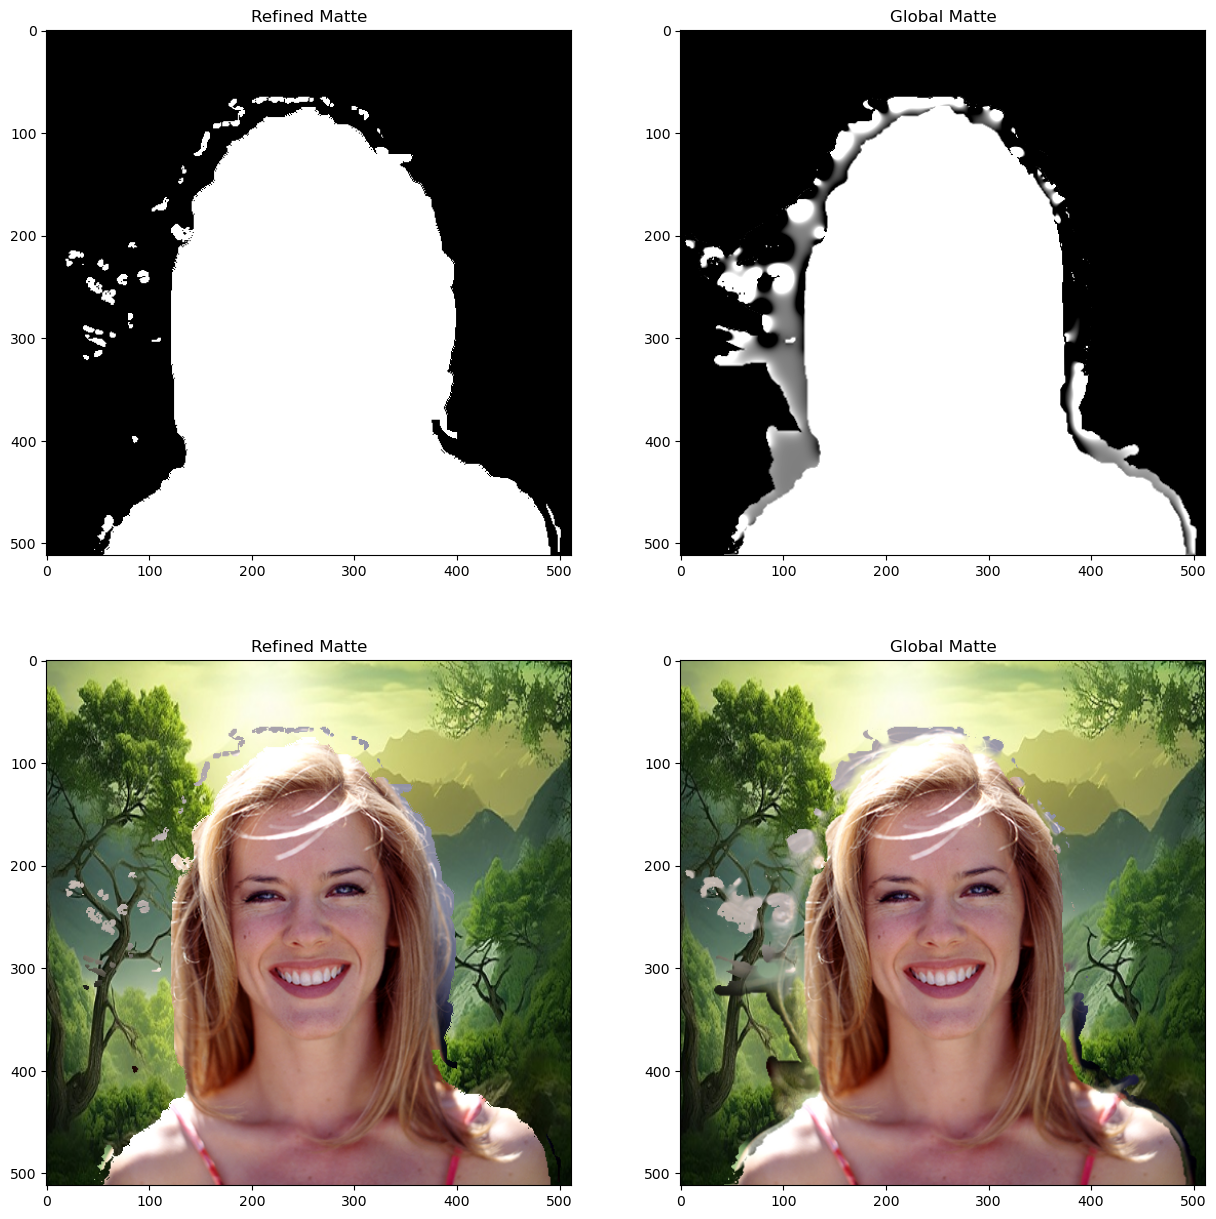

In [87]:


bg_new = bg_new[0:h, 0:w, :]
final_seg = np.zeros(bg_new.shape)
inverted_alpha = 1 - new_local_matte

final_seg[:, :, 0] = new_local_matte * org_n[:, :, 0] + inverted_alpha * bg_new[:, :, 0]
final_seg[:, :, 1] = new_local_matte * org_n[:, :, 1] + inverted_alpha * bg_new[:, :, 1]
final_seg[:, :, 2] = new_local_matte * org_n[:, :, 2] + inverted_alpha * bg_new[:, :, 2]

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(new_local_matte,cmap='gray')
plt.title("Refined Matte")
plt.subplot(222)
plt.imshow(New_alpha,cmap='gray')
plt.title("Global Matte")
plt.subplot(223)
plt.imshow(final_seg/255)
plt.title("Refined Matte")
plt.subplot(224)
plt.imshow(final/255)
plt.title("Global Matte")
plt.show()